In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

In [58]:
def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def make_table(paths, condition_dict, contexts = [0, 1, 16, 64]):
    results_interpretor = rri.RayResultsinterpreter()
    conditions = copy.deepcopy(condition_dict)
    conditions['context'] = contexts
    def custom_data_filler(out_row, reference_row):
        out_row['path'] = reference_row['path']
    df = results_interpretor.make_table(paths, conditions, custom_data_filler)

    df_print = df.copy()
    df_print.drop(['path'], axis=1, inplace=True)
    df_print.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)
    min_test_loss = df_print.groupby(['# of stores', 'warehouse_holding_cost', 'warehouse_lead_time', 'stores_correlation'])['Test Loss'].transform('min')
    df_print['Test Gap %'] = ((df_print['Test Loss'] - min_test_loss) / min_test_loss) * 100
    df_print.sort_values(by=['# of stores', 'warehouse_holding_cost', 'warehouse_lead_time', 'stores_correlation', 'context size'], inplace=True)
    print(df_print.to_string(index=False))
    return df

def make_table_with_ctx_vanilla(ctx_paths, vanilla_paths, condition_dict, contexts = [0, 1, 64]):
    condition_for_ctx = condition_dict.copy()
    condition_for_ctx['context'] = contexts
    results_interpretor = rri.RayResultsinterpreter()
    df_ctx = results_interpretor.make_table(ctx_paths, condition_for_ctx, custom_data_filler)

    df_vanilla = results_interpretor.make_table(vanilla_paths, condition_dict, custom_data_filler)
    df_vanilla.rename(columns={'learning_rate': 'Learning Rate'}, inplace=True)

    df_ctx.insert(1, 'Architecture Class', "Symmatry_Aware")
    df_vanilla.insert(1, 'Architecture Class', "Vanilla")
    df = pd.concat([df_ctx, df_vanilla])
    df['context'] = df['context'].fillna(-1).astype('int')

    df_print = df.copy()
    df_print.drop(['path'], axis=1, inplace=True)
    df_print.rename(columns={'context': 'context size', 'learning_rate': 'Learning Rate'}, inplace=True)
    min_test_loss = df_print.groupby(['# of stores', 'warehouse_holding_cost', 'warehouse_lead_time', 'stores_correlation'])['Test Loss'].transform('min')
    df_print['Test Gap %'] = ((df_print['Test Loss'] - min_test_loss) / min_test_loss) * 100

    architecture_order = ['Symmatry_Aware', 'Vanilla']
    df['Architecture Class'] = pd.Categorical(df['Architecture Class'], categories=architecture_order, ordered=True)
    df_print.sort_values(by=['# of stores', 'Architecture Class', 'warehouse_holding_cost', 'warehouse_lead_time', 'stores_correlation', 'context size'], inplace=True)
    print(df_print.to_string(index=False))
    return df

def collect_data_and_plot(df, x_axis_value):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                "test",
                "one_warehouse_lost_demand_diff_primitive",
                "symmetry_aware_grid_search",
                row['path']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",  # or "INTEL" if you want to force it
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/primitive/{row['# of stores']}/{row['warehouse_holding_cost']}_{int(row['warehouse_lead_time'])}_{row['stores_correlation']}_[{int(row['context'])}].csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_warehouse_orders = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        # Load data and calculate averages
        data = pd.read_csv(file_name)
        # Calculate means for steps 300-500 across all batches
        num_samples = 1024
        num_steps = 500
        num_batches = 4
        start_step = 300
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * num_samples * num_steps
            step_start = batch_start + start_step * num_samples
            step_end = batch_start + num_steps * num_samples
            relevant_indices.extend(range(step_start, step_end))
        
        relevant_data = data.iloc[relevant_indices]
        
        avg_s_underage.append(relevant_data['s_underage_costs'].mean())
        avg_s_holding.append(relevant_data['s_holding_costs'].mean())
        avg_w_holding.append(relevant_data['w_holding_costs'].mean())
        avg_warehouse_orders.append(relevant_data['warehouse_orders'].mean())
    # Add the calculated averages as new columns to the dataframe
    df['avg_s_underage'] = avg_s_underage
    df['avg_s_holding'] = avg_s_holding
    df['avg_w_holding'] = avg_w_holding
    df['avg_warehouse_orders'] = avg_warehouse_orders

    # Prepare data for plotting
    plot_data = df.pivot(index=x_axis_value, columns='context', 
                         values=['avg_s_underage', 'avg_s_holding', 'avg_w_holding', 'avg_warehouse_orders'])
    
    # Create subplots
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    titles = ['Store Underage Cost', 'Store Holding Cost', 'Warehouse Holding Cost', 'Warehouse Orders']
    y_values = ['avg_s_underage', 'avg_s_holding', 'avg_w_holding', 'avg_warehouse_orders']

    if x_axis_value == 'warehouse_holding_cost':
        x_values = [0.7, 1.0, 1.3, 2.0]
    elif x_axis_value == 'warehouse_lead_time':
        x_values = [2, 6]
    elif x_axis_value == 'stores_correlation':
        x_values = [-0.5, 0.0, 0.5]
    
    for i, (ax, title, y_value) in enumerate(zip(axes, titles, y_values)):
        for ctx in df['context'].unique():
            ax.plot(x_values, plot_data[y_value][ctx].loc[x_values], marker='o', label=f'Context {ctx}')
        
        ax.set_xlabel(x_axis_value.replace('_', ' ').title())
        ax.set_ylabel('Average Cost')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        ax.set_xticks(x_values)
        ax.set_xticklabels(x_values)
    
    plt.tight_layout()
    plt.show()

def make_plots_for(paths, x_axis_value, condition_dict):
    df = make_table(paths, condition_dict)
    collect_data_and_plot(df, x_axis_value)

 warehouse_holding_cost  warehouse_lead_time  stores_correlation  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  Test Gap %
                    0.7                    6                 0.5             0          0.010    5.913846  5.907117   5.913744    1.509709
                    0.7                    6                 0.5             1          0.001    5.838769  5.833972   5.833199    0.127154
                    0.7                    6                 0.5            16          0.001    5.829509  5.826976   5.827758    0.033756
                    0.7                    6                 0.5            64          0.001    5.824574  5.827352   5.825791    0.000000
                    1.0                    6                 0.5             0          0.010    5.992118  5.978688   5.996385    2.106085
                    1.0                    6                 0.5             1          0.010    5.884676  5.876438   5.877843    0.087556
                    1.0    

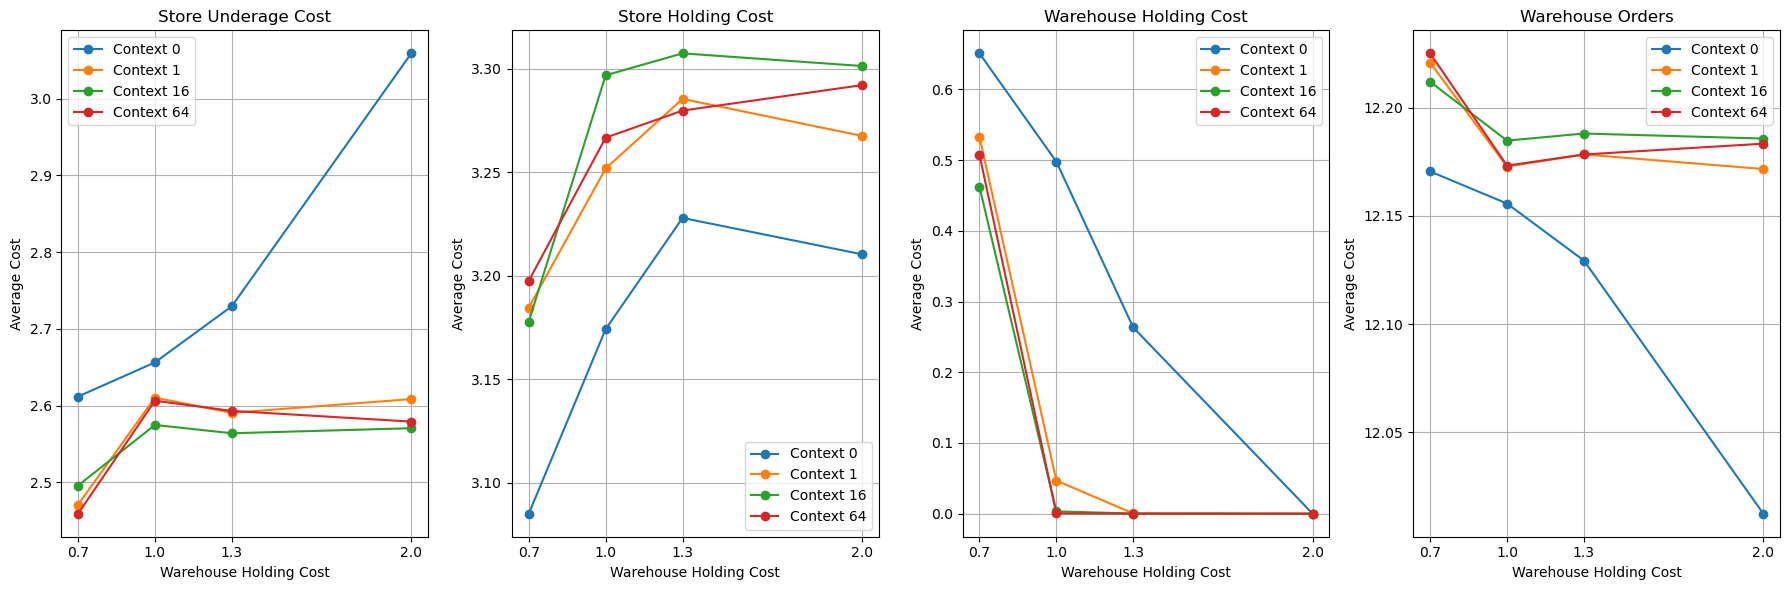

In [19]:
paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/3'
}
make_plots_for(paths, 'warehouse_holding_cost', {'warehouse_holding_cost': [0.7, 1.0, 1.3, 2.0],'warehouse_lead_time': [6], 'stores_correlation': [0.5]})

 warehouse_holding_cost  warehouse_lead_time  stores_correlation  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  Test Gap %
                    0.7                    2                 0.5             0          0.010    5.694989  5.669734   5.666458    3.427658
                    0.7                    2                 0.5             1          0.001    5.500104  5.492866   5.494882    0.295948
                    0.7                    2                 0.5            16          0.010    5.484174  5.479819   5.478668    0.000000
                    0.7                    2                 0.5            64          0.001    5.481597  5.478923   5.478881    0.003888
                    0.7                    6                 0.5             0          0.010    5.913846  5.907117   5.913744    1.509709
                    0.7                    6                 0.5             1          0.001    5.843374  5.837429   5.838852    0.224195
                    0.7    

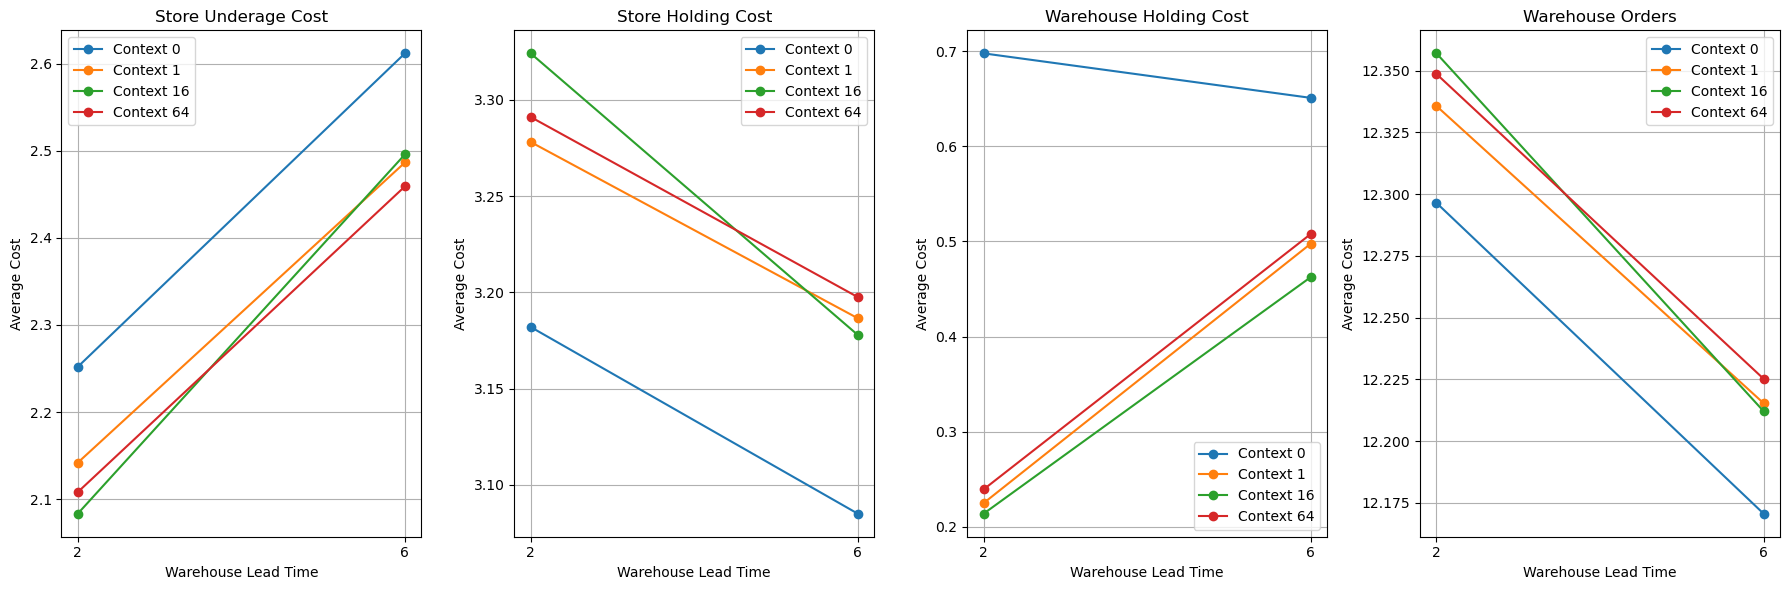

In [19]:
paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx'
}
make_plots_for(paths, 'warehouse_lead_time', {'warehouse_holding_cost': [0.7],'warehouse_lead_time': [2, 6], 'stores_correlation': [0.5]})

 warehouse_holding_cost  warehouse_lead_time  stores_correlation  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  Test Gap %
                    2.0                    2                 0.5             0          0.001    5.915934  5.905802   5.911411    7.569464
                    2.0                    2                 0.5             1          0.001    5.513087  5.508841   5.510422    0.272700
                    2.0                    2                 0.5            16          0.001    5.497995  5.495228   5.495436    0.000000
                    2.0                    2                 0.5            64          0.001    5.497965  5.495389   5.495760    0.005892
                    2.0                    6                 0.5             0          0.010    6.197375  6.143627   6.269510    6.783597
                    2.0                    6                 0.5             1          0.010    5.896185  5.874366   5.876068    0.082399
                    2.0    

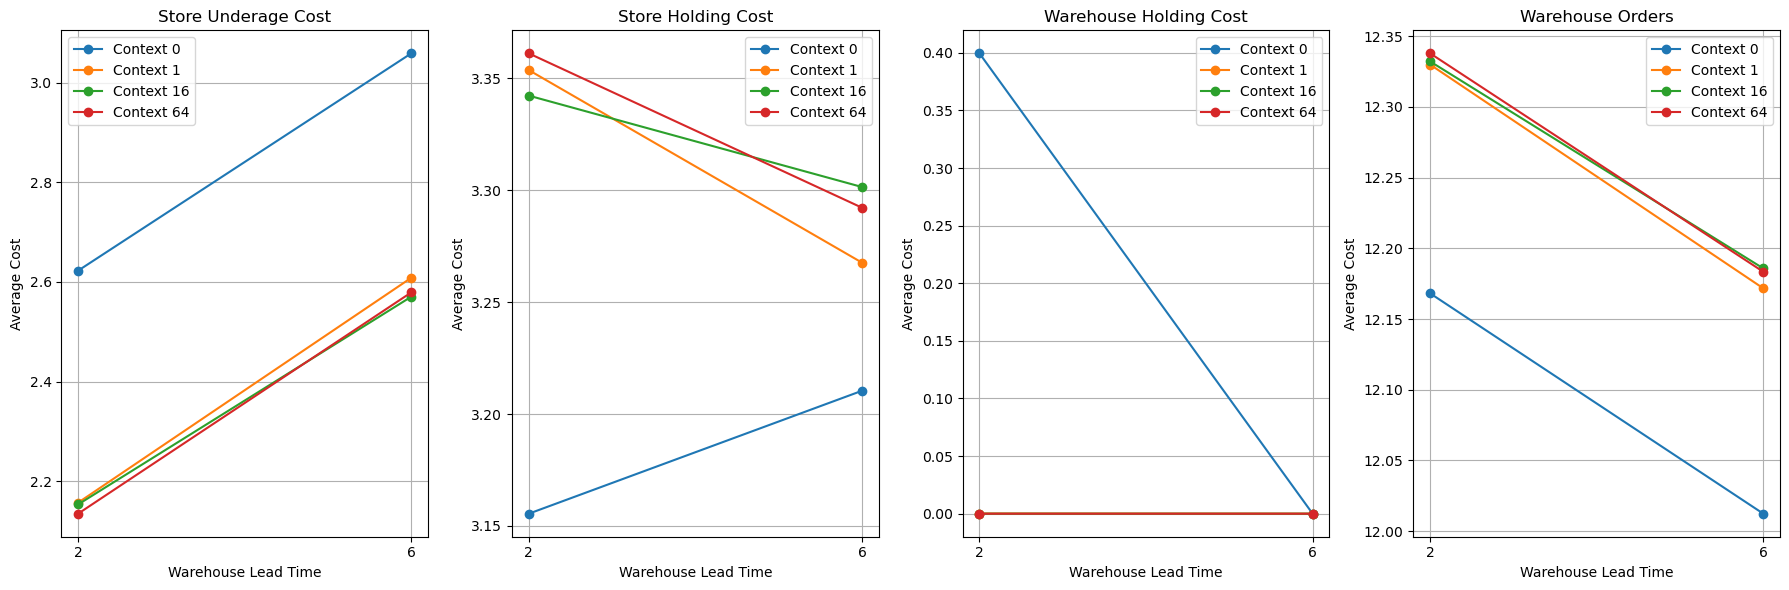

In [20]:
paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx'
}
make_plots_for(paths, 'warehouse_lead_time', {'warehouse_holding_cost': [2.0],'warehouse_lead_time': [2, 6], 'stores_correlation': [0.5]})

 warehouse_holding_cost  warehouse_lead_time  stores_correlation  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  Test Gap %
                    0.7                    6                -0.5             0          0.010    5.228738  5.237459   5.229138    0.718822
                    0.7                    6                -0.5             1          0.010    5.193958  5.200948   5.193782    0.037813
                    0.7                    6                -0.5            16          0.001    5.191816  5.199106   5.192705    0.017070
                    0.7                    6                -0.5            64          0.001    5.189119  5.198813   5.191818    0.000000
                    0.7                    6                 0.0             0          0.001    5.604022  5.613331   5.612740    1.504944
                    0.7                    6                 0.0             1          0.001    5.526807  5.540596   5.533923    0.079568
                    0.7    

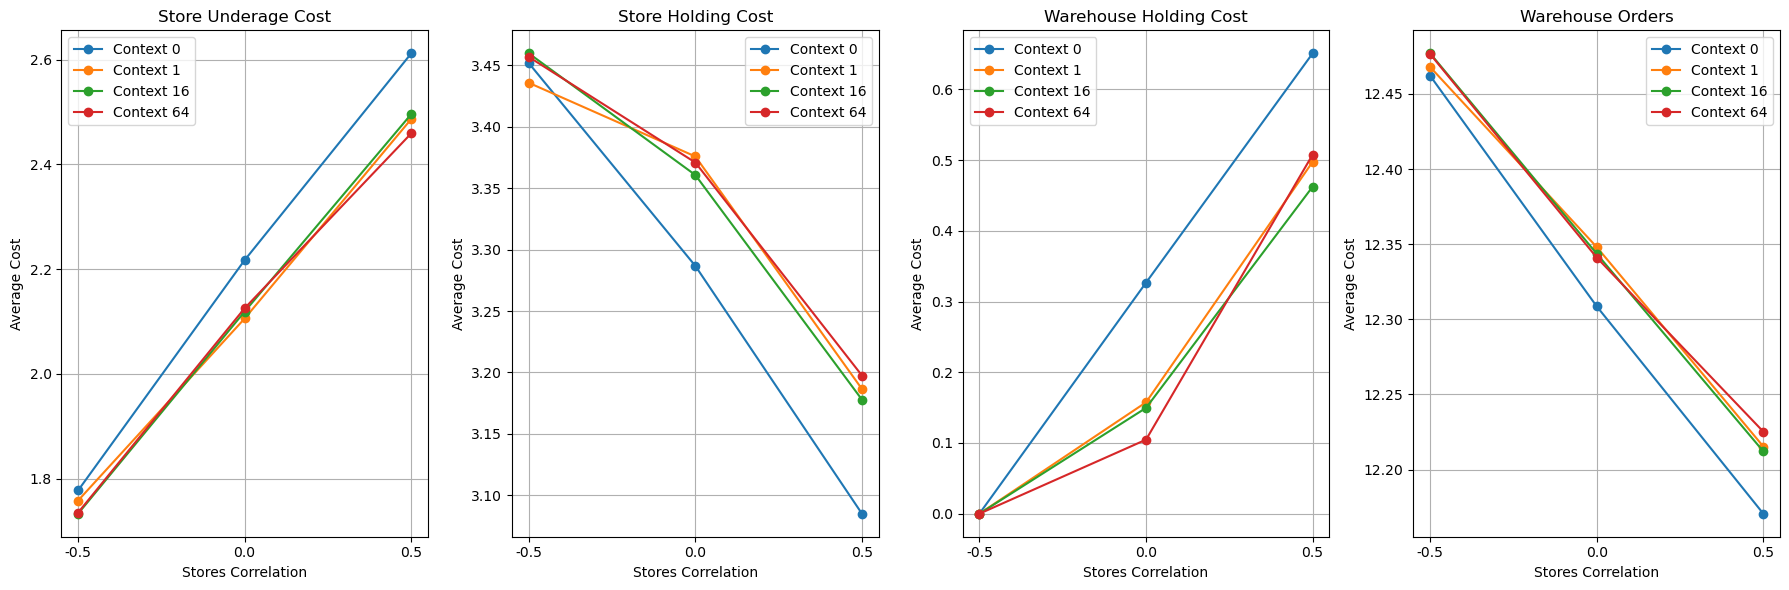

In [21]:
paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx'
}
make_plots_for(paths, 'stores_correlation', {'warehouse_holding_cost': [0.7],'warehouse_lead_time': [6], 'stores_correlation': [-0.5, 0.0, 0.5]})

 warehouse_holding_cost  warehouse_lead_time  stores_correlation  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  Test Gap %
                    2.0                    6                -0.5             0          0.001    5.227845  5.237849   5.229256    0.712480
                    2.0                    6                -0.5             1          0.010    5.194059  5.201558   5.195194    0.056469
                    2.0                    6                -0.5            16          0.010    5.193197  5.199802   5.192262    0.000000
                    2.0                    6                -0.5            64          0.001    5.192500  5.200326   5.193359    0.021132
                    2.0                    6                 0.0             0          0.001    5.712041  5.707703   6.209399   12.103240
                    2.0                    6                 0.0             1          0.001    5.534035  5.546531   5.540761    0.031781
                    2.0    

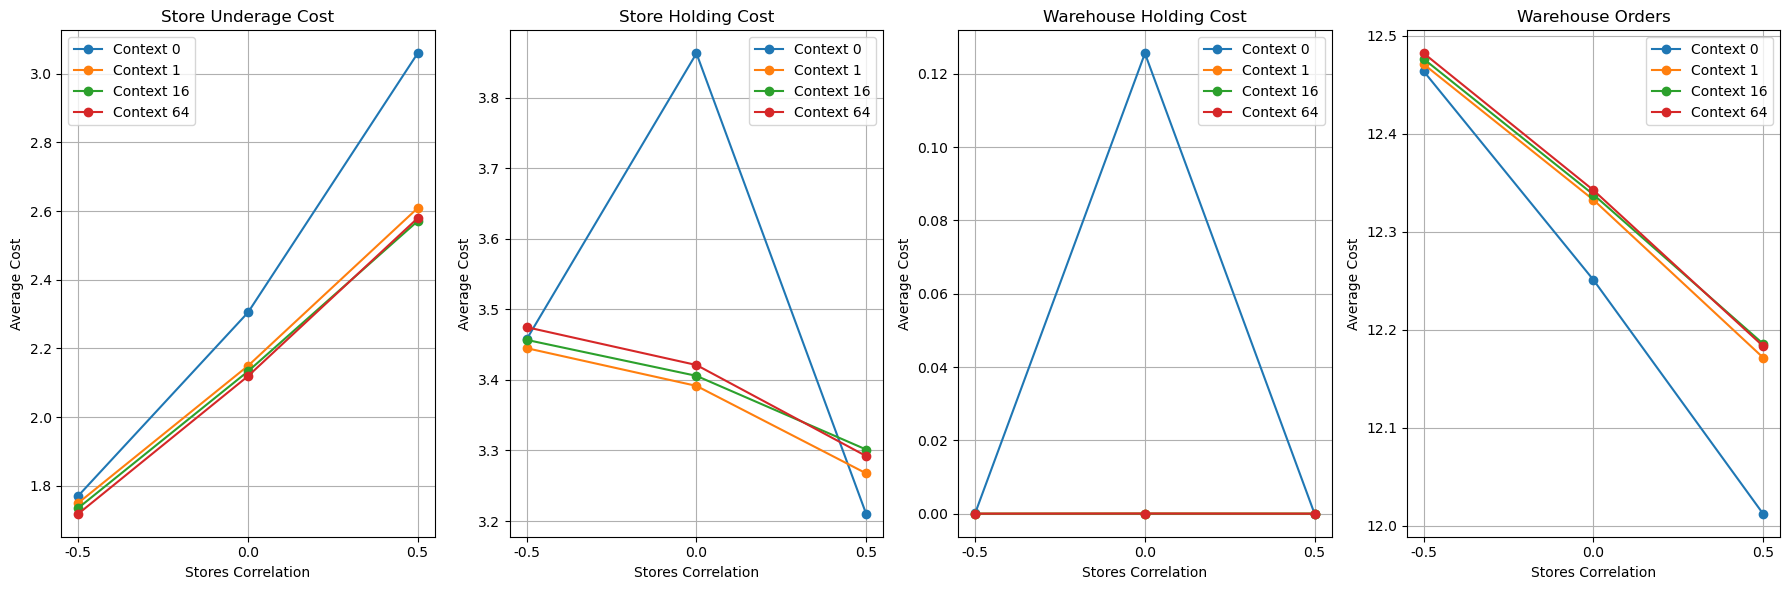

In [22]:
paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx'
}
make_plots_for(paths, 'stores_correlation', {'warehouse_holding_cost': [2.0],'warehouse_lead_time': [6], 'stores_correlation': [-0.5, 0.0, 0.5]})

In [61]:
ctx_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/3',
    10: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/10',
    20: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/20',
    50: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/50'
}
vanilla_paths = {
    3: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/3',
    10: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/10',
    20: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/20',
    50: '/user/ml4723/Prj/NIC/ray_results/diff_primitive/vanilla/50'
}

shared_conditions = {'warehouse_holding_cost': [0.7], 'warehouse_lead_time': [2], 'stores_correlation': [0.5]}
df = make_table_with_ctx_vanilla(ctx_paths, vanilla_paths, shared_conditions)
collect_data_and_plot(df, '# of stores')

 # of stores Architecture Class  warehouse_holding_cost  warehouse_lead_time  stores_correlation  context size  Learning Rate  Train Loss  Dev Loss  Test Loss  Test Gap %
           3     Symmatry_Aware                     0.7                    2                 0.5             0         0.0100    5.694989  5.669734   5.666458    3.423637
           3     Symmatry_Aware                     0.7                    2                 0.5             1         0.0100    5.492721  5.486079   5.484402    0.100769
           3     Symmatry_Aware                     0.7                    2                 0.5            64         0.0010    5.481597  5.478923   5.478881    0.000000
           3            Vanilla                     0.7                    2                 0.5            -1         0.0001    5.507400  5.498954   5.498823    0.363985
          10     Symmatry_Aware                     0.7                    2                 0.5             0         0.0100    5.692854  5.6723

FileNotFoundError: [Errno 2] No such file or directory: 'results/primitive/10/0.7_2_0.5_[1].csv'

In [ ]:
# Print the DataFrame with better formatting for long paths
pd.set_option('display.max_colwidth', None)  # Set column width to unlimited
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.width', None)  # Set display width to unlimited

# Print the DataFrame
print(df.to_string())

# Reset display options to default (optional)
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')


    # of stores Architecture Class  warehouse_holding_cost  warehouse_lead_time  stores_correlation  context  Learning Rate  Train Loss  Dev Loss  Test Loss                                                                                                                                                                                                                                   path
0             3                NaN                     0.7                    2                 0.5        0         0.0100    5.694989  5.669734   5.666458   /user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/3/run_2024-08-01_20-29-16/run_40484_00000_0_context=0,learning_rate=0.0100,samples=1,stores_correlation=0.5000,warehouse_holding_cost=0.7000,warehouse_lead__2024-08-01_20-29-16
1             3                NaN                     0.7                    2                 0.5        1         0.0100    5.492721  5.486079   5.484402   /user/ml4723/Prj/NIC/ray_results/diff_primitive/ctx/3/run_2024-08